The purpose of this notebook is to fix some issues caused by AMPL 1.6.1 

Created by Rose Wilfong on May 24, 2024

In [1]:
# library time 
from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp
from atomsci.ddm.pipeline import perf_plots as pp
import pandas as pd
pd.set_option('display.max_columns', None)

# ignore warnings in tutorials
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

Skipped loading some Jax models, missing a dependency. No module named 'haiku'
/opt/anaconda3/envs/atomsci-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
## Read in data 
result_df=pd.read_csv('dataset/SLC6A3_models/07_example_pred_df.csv', index_col=0)

result_df=result_df.sort_values('best_valid_r2_score', ascending=False)
print(result_df.shape)
result_df.head(2)

(467, 41)


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict
310,b24a2887-8eca-43e2-8fc2-3642189d2c94,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.562091,0.776865,0.585176,0.43255,1273,0.562091,0.799156,0.629897,273,0.519325,0.840682,0.649599,273,NaN,NaN,NaN,100.0,24.0,0.000083,"369,283,146","0.28,0.30,0.30",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
306,9b6c9332-15f3-4f96-9579-bf407d0b69a8,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.559590,0.950677,0.275124,0.19340,1273,0.559590,0.801435,0.649692,273,0.480895,0.873642,0.693995,273,129.0,95.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"


In [20]:
# filter out objectively bad performing models
result_df=result_df[result_df.best_valid_r2_score>0.1]
result_df.shape

(264, 41)

In [21]:
# model counts
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter,fingerprint,scaffold,fingerprint,scaffold
features,ecfp,ecfp,rdkit_raw,rdkit_raw
model_type,,,,
NN,8.0,23.0,11.0,86.0
RF,NaN,30.0,NaN,32.0
xgboost,3.0,21.0,NaN,50.0


From this, we know there should be two feature types plotted. ECFP and rdkit_raw. 

#### Manually inserting functions from HPP

In [23]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Create an array with the colors you want to use
colors = ["#7682A4","#A7DDD8","#373C50","#694691","#BE2369","#EB1E23","#6EC8BE","#FFC30F",]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)
plt.rcParams.update({"figure.dpi": 96})

from atomsci.ddm.pipeline import parameter_parser as pp

# get all possible things to plot from parameter parser
parser=pp.get_parser()
d=vars(pp.get_parser().parse_args([]))
keywords=['AttentiveFPModel','GCNModel','GraphConvModel','MPNNModel','PytorchMPNNModel','rf_','xgb_']
plot_dict={}
for word in keywords:
    tmplist=[x for x in d.keys() if x.startswith(word)]
    if word=='rf_': word='RF'
    elif word=='xgb_':word='xgboost'
    plot_dict[word]=tmplist
plot_dict['general']=['model_type','features','splitter']#'ecfp_radius',
plot_dict['NN']=['avg_dropout','learning_rate','num_nodes','num_layers','best_epoch','max_epochs']

# list score types
regselmets=[
 'r2_score',
 'mae_score',
 'rms_score',
]
classselmets = [
 'roc_auc_score',
 'prc_auc_score',
 'precision',
 'recall_score',
 'npv',
 'accuracy_score',
 'kappa',
 'matthews_cc',
 'bal_accuracy',
]

In [19]:
def _prep_perf_df(df):
    """This function splits columns that contain lists into individual columns to use for plotting later.
    
    Args:
        df (pd.DataFrame): A dataframe containing model performances from a hyperparameter search. Best practice is to use get_multitask_perf_from_tracker() or get_filesystem_perf_results().
        
    Returns:
        perf_track_df (pd.DataFrame): a new df with modified and extra columns.
    """
    perf_track_df=df.copy()

    if 'model_parameters_dict' in perf_track_df:
        
        exp=pd.DataFrame(perf_track_df.model_parameters_dict.tolist())
        # resetting index 
        exp.reset_index(drop=True, inplace=True)
        perf_track_df.reset_index(drop=True, inplace=True)
        exp['model_uuid']=perf_track_df.model_uuid
        perf_track_df=perf_track_df.merge(exp)
    
    if 'NN' in perf_track_df.model_type.unique():
        
        cols=['dummy_nodes_1','dummy_nodes_2','dummy_nodes_3']
        
        # dropouts
        tmp=perf_track_df.dropouts.astype(str).str.strip('[]').str.split(pat=',', expand=True).astype(float)
        n=len(tmp.columns)
        perf_track_df[cols[0:n]]=tmp
        perf_track_df['avg_dropout']=perf_track_df[cols[0:n]].mean(axis=1)
        
        # layer sizes
        tmp= perf_track_df.layer_sizes.astype(str).str.strip('[]').str.split(pat=',', expand=True).astype(float)
        perf_track_df[cols[0:n]]=tmp
        perf_track_df['num_layers'] = n-perf_track_df[cols[0:n]].isna().sum(axis=1)
        perf_track_df[cols[0:n]]=perf_track_df[cols[0:n]].fillna(value=1).astype(int)
        perf_track_df['num_nodes']=perf_track_df[cols[0:n]].product(axis=1)
        perf_track_df.num_nodes=perf_track_df.num_nodes.astype(float)
        # perf_track_df=perf_track_df.drop(columns=cols[0:n])
        
        perf_track_df.loc[perf_track_df.model_type != "NN", 'layer_sizes']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'num_layers']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'num_nodes']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'avg_dropout']=np.nan
    
    return perf_track_df


In [22]:
def plot_split_perf(df, prediction_type='regression', subset='valid'):
    """This function creates boxplots of performance scores based on the splitter type.
    
    Args:
        df (pd.DataFrame): A dataframe containing model performances from a hyperparameter search. Best practice is to use get_multitask_perf_from_tracker() or get_filesystem_perf_results().
        
        prediction_type (str): the type of model you want to visualize. Valid options are "regression" and "classification".  
        
        subset (str): the subset of scores you'd like to plot from 'train', 'valid' and 'test'.
    """
    sns.set_context("notebook")    
    perf_track_df=_prep_perf_df(df).reset_index(drop=True)
    
    if prediction_type=='regression':
        selmets=regselmets
    elif prediction_type=='classification':
        selmets=classselmets
        
    plot_df=perf_track_df
    plot_df=plot_df.sort_values('features')
    with sns.axes_style("ticks"):
        fig, axes = plt.subplots(1,len(selmets), figsize=(5*len(selmets),5))
        for i, ax in enumerate(axes.flat):
            if i==len(axes.flat)-1:
                legend=True
            else:
                legend=False
            selection_metric = f'best_{subset}_{selmets[i]}'
            sns.boxplot(x="features", y=selection_metric, # x="txptr_features" x="model_type"
                        hue='splitter', palette = sns.color_palette(colors[0:plot_df.splitter.nunique()]), #showfliers=False, 
                          legend=legend,
                        data=plot_df, ax=ax);
            ax.set_xlabel('')
            ax.set_ylabel(selection_metric.replace(f'best_{subset}_',''))
            ax.set_xticks(ax.get_xticks()) # avoid warning by including this line
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor' )
            ax.set_title(selection_metric.replace(f'best_{subset}_',''))
            if legend: sns.move_legend(ax, loc=(1.01,0.5))
        plt.tight_layout()
        fig.suptitle('Effect of splitter on model performance', y=1.01)



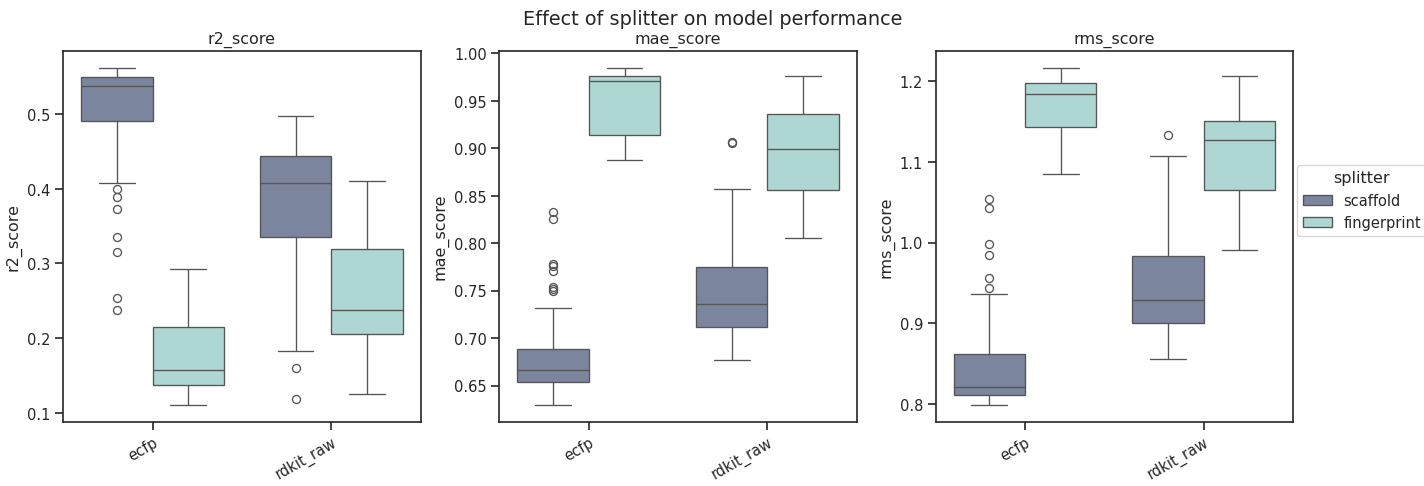

In [20]:
plot_split_perf(result_df, subset='valid')

### Now Plotting With Implemented Fix
There is an issue with the merging I believe and this is why it is removing the other featurizer, which is ecfp. 

In [10]:
def _prep_perf_df(df):
    """This function splits columns that contain lists into individual columns to use for plotting later.
    
    Args:
        df (pd.DataFrame): A dataframe containing model performances from a hyperparameter search. Best practice is to use get_multitask_perf_from_tracker() or get_filesystem_perf_results().
        
    Returns:
        perf_track_df (pd.DataFrame): a new df with modified and extra columns.
    """
    perf_track_df=df.copy()
    
    # comment out for sake of testing
    if 'model_parameters_dict' in perf_track_df:
        exp=pd.DataFrame(perf_track_df.model_parameters_dict.tolist())
        exp['model_uuid']=perf_track_df.model_uuid
        perf_track_df=perf_track_df.merge(exp)
    
    if 'NN' in perf_track_df.model_type.unique():
        
        cols=['dummy_nodes_1','dummy_nodes_2','dummy_nodes_3']
        
        # dropouts
        tmp=perf_track_df.dropouts.astype(str).str.strip('[]').str.split(pat=',', expand=True).astype(float)
        n=len(tmp.columns)
        perf_track_df[cols[0:n]]=tmp
        perf_track_df['avg_dropout']=perf_track_df[cols[0:n]].mean(axis=1)
        
        # layer sizes
        tmp= perf_track_df.layer_sizes.astype(str).str.strip('[]').str.split(pat=',', expand=True).astype(float)
        perf_track_df[cols[0:n]]=tmp
        perf_track_df['num_layers'] = n-perf_track_df[cols[0:n]].isna().sum(axis=1)
        perf_track_df[cols[0:n]]=perf_track_df[cols[0:n]].fillna(value=1).astype(int)
        perf_track_df['num_nodes']=perf_track_df[cols[0:n]].product(axis=1)
        perf_track_df.num_nodes=perf_track_df.num_nodes.astype(float)
        # perf_track_df=perf_track_df.drop(columns=cols[0:n])
        
        perf_track_df.loc[perf_track_df.model_type != "NN", 'layer_sizes']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'num_layers']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'num_nodes']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'avg_dropout']=np.nan
    
    return perf_track_df


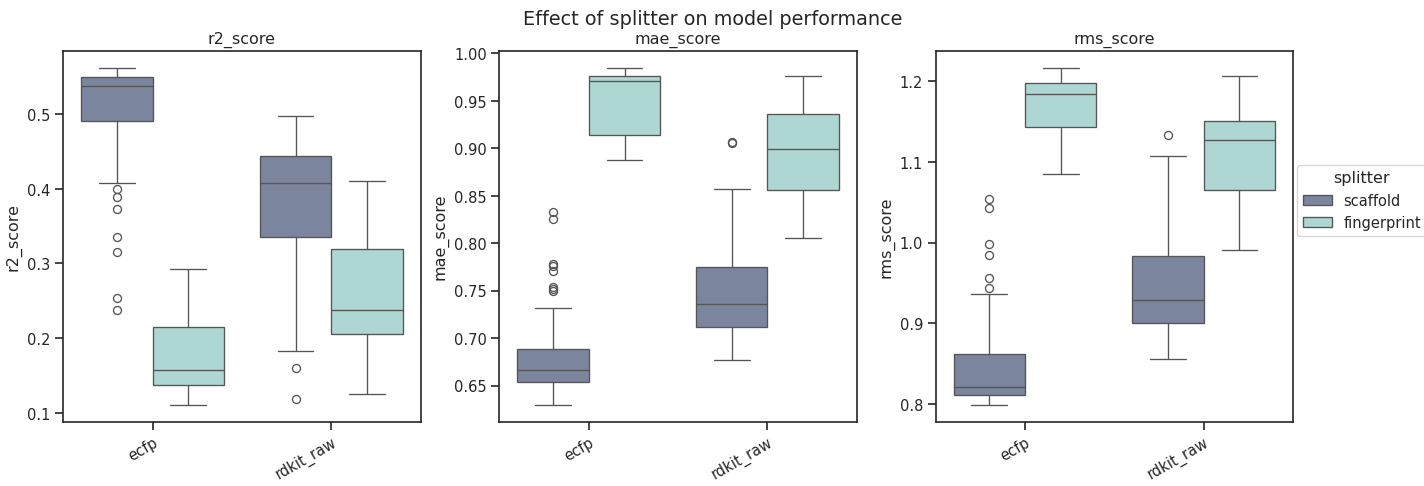

In [11]:
plot_split_perf(result_df, subset='valid')

## Let's break down what is happening with the merging

In [3]:
# a look at the original dataframe
result_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict
310,b24a2887-8eca-43e2-8fc2-3642189d2c94,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,5.620908e-01,7.768647e-01,5.851759e-01,4.325495e-01,1273,5.620908e-01,7.991562e-01,6.298971e-01,273,5.193249e-01,8.406818e-01,6.495992e-01,273,NaN,NaN,NaN,100.0,24.0,0.000083,"369,283,146","0.28,0.30,0.30",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
306,9b6c9332-15f3-4f96-9579-bf407d0b69a8,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,5.595900e-01,9.506765e-01,2.751244e-01,1.934002e-01,1273,5.595900e-01,8.014349e-01,6.496925e-01,273,4.808951e-01,8.736417e-01,6.939953e-01,273,129.0,95.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
291,d8e25713-bf6c-4ba0-917a-69f0ea1472b9,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,5.571565e-01,9.307258e-01,3.260528e-01,2.440183e-01,1273,5.571565e-01,8.036460e-01,6.564590e-01,273,4.971922e-01,8.598186e-01,6.868194e-01,273,176.0,77.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
334,1a3e4b13-f860-4acf-8300-e2ac5766caa6,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,5.566793e-01,8.013912e-01,5.520793e-01,4.069349e-01,1273,5.566793e-01,8.040789e-01,6.377773e-01,273,5.235667e-01,8.369642e-01,6.544680e-01,273,NaN,NaN,NaN,100.0,66.0,0.000045,"190,361,230","0.40,0.26,0.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 66, ""dropouts"": [0.397143286660...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
321,57a62e20-f18e-4afa-8ce2-315f0fcc950a,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,5.561033e-01,7.806933e-01,5.801338e-01,4.328974e-01,1273,5.561033e-01,8.046011e-01,6.377640e-01,273,5.212697e-01,8.389793e-01,6.550669e-01,273,NaN,NaN,NaN,100.0,64.0,0.000033,"249,228,310","0.39,0.05,0.10",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 64, ""dropouts"": [0.391578043734...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,5f025274-d06f-45d7-9e81-651e03b94392,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,xgboost,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,rdkit_raw,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,-3.386422e+55,-3.218222e+55,7.027651e+27,7.027651e+27,1273,-3.386422e+55,7.027651e+27,7.027651e+27,273,-3.358990e+55,

In [13]:
(result_df['model_parameters_dict'])

310    {"best_epoch": 24, "dropouts": [0.278664215998...
306    {"rf_estimators": 129, "rf_max_depth": 32, "rf...
291    {"rf_estimators": 176, "rf_max_depth": 20, "rf...
334    {"best_epoch": 66, "dropouts": [0.397143286660...
321    {"best_epoch": 64, "dropouts": [0.391578043734...
                             ...                        
457    {"best_epoch": 12, "dropouts": [0.269788830116...
273    {"best_epoch": 11, "dropouts": [0.397022041468...
380    {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.4...
173    {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.0...
449    {"best_epoch": 3, "dropouts": [0.1092146433602...
Name: model_parameters_dict, Length: 264, dtype: object

In [26]:
# let's get counts of the features 
result_df['features'].value_counts()

features
rdkit_raw    179
ecfp          85
Name: count, dtype: int64

In [13]:
result_df.reset_index(drop=True, inplace=True)

##### Step by step

In [5]:
# first, make a copy of the dataframe I'm working with 
perf_track_df=result_df.copy()

In [6]:
perf_track_df.head()

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict
310,b24a2887-8eca-43e2-8fc2-3642189d2c94,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.562091,0.776865,0.585176,0.432550,1273,0.562091,0.799156,0.629897,273,0.519325,0.840682,0.649599,273,NaN,NaN,NaN,100.0,24.0,0.000083,"369,283,146","0.28,0.30,0.30",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
306,9b6c9332-15f3-4f96-9579-bf407d0b69a8,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.559590,0.950677,0.275124,0.193400,1273,0.559590,0.801435,0.649692,273,0.480895,0.873642,0.693995,273,129.0,95.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
291,d8e25713-bf6c-4ba0-917a-69f0ea1472b9,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.557156,0.930726,0.326053,0.244018,1273,0.557156,0.803646,0.656459,273,0.497192,0.859819,0.686819,273,176.0,77.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
334,1a3e4b13-f860-4acf-8300-e2ac5766caa6,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.556679,0.801391,0.552079,0.406935,1273,0.556679,0.804079,0.637777,273,0.523567,0.836964,0.654468,273,NaN,NaN,NaN,100.0,66.0,0.000045,"190,361,230","0.40,0.26,0.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 66, ""dropouts"": [0.397143286660...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
321,57a62e20-f18e-4afa-8ce2-315f0fcc950a,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.556103,0.780693,0.580134,0.432897,1273,0.556103,0.804601,0.637764,273,0.521270,0.838979,0.655067,273,NaN,NaN,NaN,100.0,64.0,0.000033,"249,228,310","0.39,0.05,0.10",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 64, ""dropouts"": [0.391578043734...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"


In [7]:
exp=pd.DataFrame(perf_track_df.model_parameters_dict.tolist())

In [8]:
exp

,0
0,"{""best_epoch"": 24, ""dropouts"": [0.278664215998..."
1,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf..."
2,"{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf..."
3,"{""best_epoch"": 66, ""dropouts"": [0.397143286660..."
4,"{""best_epoch"": 64, ""dropouts"": [0.391578043734..."
...,...
259,"{""best_epoch"": 12, ""dropouts"": [0.269788830116..."
260,"{""best_epoch"": 11, ""dropouts"": [0.397022041468..."
261,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.4..."
262,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0..."


In [9]:
exp['model_uuid']=perf_track_df.model_uuid

In [10]:
exp

,0,model_uuid
0,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...",0432f4b8-cf3e-4a29-9f59-93d835da3860
1,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...",03131165-0c65-45bd-b9f2-e2e085f65683
2,"{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf...",19aadcfe-cb64-4027-9c8c-11c277ae1263
3,"{""best_epoch"": 66, ""dropouts"": [0.397143286660...",41ed9a7a-6b44-455a-9544-292cd8cd7e51
4,"{""best_epoch"": 64, ""dropouts"": [0.391578043734...",00f56b95-24eb-40d0-b0c4-384c62954c99
...,...,...
259,"{""best_epoch"": 12, ""dropouts"": [0.269788830116...",NaN
260,"{""best_epoch"": 11, ""dropouts"": [0.397022041468...",NaN
261,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.4...",NaN
262,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",86768e48-41f9-4ce7-8c26-24ab0d145271


In [11]:
exp_nan = exp[exp['model_uuid'].isna()]

In [12]:
exp_nan

,0,model_uuid
32,"{""best_epoch"": 3, ""dropouts"": [0.0123911606830...",NaN
39,"{""best_epoch"": 5, ""dropouts"": [0.3340401131113...",NaN
45,"{""best_epoch"": 96, ""dropouts"": [0.363504726716...",NaN
47,"{""best_epoch"": 99, ""dropouts"": [0.166150089202...",NaN
59,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...",NaN
...,...,...
258,"{""best_epoch"": 7, ""dropouts"": [0.2175603729100...",NaN
259,"{""best_epoch"": 12, ""dropouts"": [0.269788830116...",NaN
260,"{""best_epoch"": 11, ""dropouts"": [0.397022041468...",NaN
261,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.4...",NaN


In [20]:
perf_track_df=perf_track_df.merge(exp)

In [21]:
perf_track_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict,0
0,b24a2887-8eca-43e2-8fc2-3642189d2c94,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.562091,0.776865,0.585176,0.432550,1273,0.562091,0.799156,0.629897,273,0.519325,0.840682,0.649599,273,NaN,NaN,NaN,100.0,24.0,0.000083,"369,283,146","0.28,0.30,0.30",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""best_epoch"": 24, ""dropouts"": [0.278664215998..."
1,9b6c9332-15f3-4f96-9579-bf407d0b69a8,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.559590,0.950677,0.275124,0.193400,1273,0.559590,0.801435,0.649692,273,0.480895,0.873642,0.693995,273,129.0,95.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf..."
2,d8e25713-bf6c-4ba0-917a-69f0ea1472b9,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.557156,0.930726,0.326053,0.244018,1273,0.557156,0.803646,0.656459,273,0.497192,0.859819,0.686819,273,176.0,77.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf..."
3,1a3e4b13-f860-4acf-8300-e2ac5766caa6,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.556679,0.801391,0.552079,0.406935,1273,0.556679,0.804079,0.637777,273,0.523567,0.836964,0.654468,273,NaN,NaN,NaN,100.0,66.0,0.000045,"190,361,230","0.40,0.26,0.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 66, ""dropouts"": [0.397143286660...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""best_epoch"": 66, ""dropouts"": [0.397143286660..."
4,57a62e20-f18e-4afa-8ce2-315f0fcc950a,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.556103,0.780693,0.580134,0.432897,1273,0.556103,0.804601,0.637764,273,0.521270,0.838979,0.655067,273,NaN,NaN,NaN,100.0,64.0,0.000033,"249,228,310","0.39,0.05,0.10",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 64, ""dropouts"": [0.391578043734...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""best_epoch"": 64, ""dropouts"": [0.391578043734..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,816ed4bb-fc0a-4b87-93f8-220066c3b7f6,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,fingerprint,train_valid_test,be60c264-6ac0-4841-a6b6-41bf846e4ae4,r2,normalization,0.131952,0.388091,0.969367,0.783295,1273,0.131

In [10]:
if 'model_parameters_dict' in perf_track_df:
    exp=pd.DataFrame(perf_track_df.model_parameters_dict.tolist())
    #exp.reset_index(drop=True, inplace=True)
    #perf_track_df.reset_index(drop=True, inplace=True)
    exp['model_uuid']=perf_track_df.model_uuid
    perf_track_df=perf_track_df.merge(exp)

In [15]:
print("After expanding model_parameters_dict:")
print(perf_track_df.shape)

After expanding model_parameters_dict:
(170, 42)


In [11]:
perf_track_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict,0
0,b24a2887-8eca-43e2-8fc2-3642189d2c94,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.562091,0.776865,0.585176,0.432550,1273,0.562091,0.799156,0.629897,273,0.519325,0.840682,0.649599,273,NaN,NaN,NaN,100.0,24.0,0.000083,"369,283,146","0.28,0.30,0.30",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""best_epoch"": 24, ""dropouts"": [0.278664215998..."
1,9b6c9332-15f3-4f96-9579-bf407d0b69a8,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.559590,0.950677,0.275124,0.193400,1273,0.559590,0.801435,0.649692,273,0.480895,0.873642,0.693995,273,129.0,95.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf..."
2,d8e25713-bf6c-4ba0-917a-69f0ea1472b9,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.557156,0.930726,0.326053,0.244018,1273,0.557156,0.803646,0.656459,273,0.497192,0.859819,0.686819,273,176.0,77.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""rf_estimators"": 176, ""rf_max_depth"": 20, ""rf..."
3,1a3e4b13-f860-4acf-8300-e2ac5766caa6,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.556679,0.801391,0.552079,0.406935,1273,0.556679,0.804079,0.637777,273,0.523567,0.836964,0.654468,273,NaN,NaN,NaN,100.0,66.0,0.000045,"190,361,230","0.40,0.26,0.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 66, ""dropouts"": [0.397143286660...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""best_epoch"": 66, ""dropouts"": [0.397143286660..."
4,57a62e20-f18e-4afa-8ce2-315f0fcc950a,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.556103,0.780693,0.580134,0.432897,1273,0.556103,0.804601,0.637764,273,0.521270,0.838979,0.655067,273,NaN,NaN,NaN,100.0,64.0,0.000033,"249,228,310","0.39,0.05,0.10",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 64, ""dropouts"": [0.391578043734...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}","{""best_epoch"": 64, ""dropouts"": [0.391578043734..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,816ed4bb-fc0a-4b87-93f8-220066c3b7f6,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,fingerprint,train_valid_test,be60c264-6ac0-4841-a6b6-41bf846e4ae4,r2,normalization,0.131952,0.388091,0.969367,0.783295,1273,0.131

In [27]:
perf_track_df['features'].value_counts()

features
rdkit_raw    170
Name: count, dtype: int64

#### Next question: Why?

In [28]:
exp=pd.DataFrame(perf_track_df.model_parameters_dict.tolist())
print(exp)

                                                     0
0    {"rf_estimators": 102, "rf_max_depth": 17, "rf...
1    {"rf_estimators": 500, "rf_max_depth": null, "...
2    {"rf_estimators": 437, "rf_max_depth": 13, "rf...
3    {"rf_estimators": 179, "rf_max_depth": 14, "rf...
4    {"rf_estimators": 460, "rf_max_depth": 20, "rf...
..                                                 ...
165  {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.1...
166  {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.2...
167  {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.0...
168  {"best_epoch": 299, "dropouts": [0.47006804156...
169  {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.0...

[170 rows x 1 columns]


In [29]:
exp['model_uuid']=perf_track_df.model_uuid

In [30]:
exp['model_uuid']

0      41ed9a7a-6b44-455a-9544-292cd8cd7e51
1      03131165-0c65-45bd-b9f2-e2e085f65683
2      f1f92564-72dd-4d20-8926-f3da098ee58b
3      5d5644da-29c3-4e89-aecd-29c2a840baa2
4      3d0fc744-dc7f-4120-bb13-237ff9c85c99
                       ...                 
165    39935929-d2fb-4d02-9f95-1fd5bfeabba8
166    d0d9a493-c06d-418d-b119-fa0083390d20
167    ab63279a-318c-45fc-9f07-6460ce7091cf
168    3a25fa51-5fb8-487c-8dab-7cf32034d5b5
169    34f8786f-d37d-41bb-a808-e199c902eceb
Name: model_uuid, Length: 170, dtype: object

In [33]:
perf_track_df.model_parameters_dict

0      {"rf_estimators": 102, "rf_max_depth": 17, "rf...
1      {"rf_estimators": 500, "rf_max_depth": null, "...
2      {"rf_estimators": 437, "rf_max_depth": 13, "rf...
3      {"rf_estimators": 179, "rf_max_depth": 14, "rf...
4      {"rf_estimators": 460, "rf_max_depth": 20, "rf...
                             ...                        
165    {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.1...
166    {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.2...
167    {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.0...
168    {"best_epoch": 299, "dropouts": [0.47006804156...
169    {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.0...
Name: model_parameters_dict, Length: 170, dtype: object

This is because there are only 170 model_uuids and it was merging back onto the dataframe, dropping those associated with ecfp features. 

### Looking at the next function that was also messed up

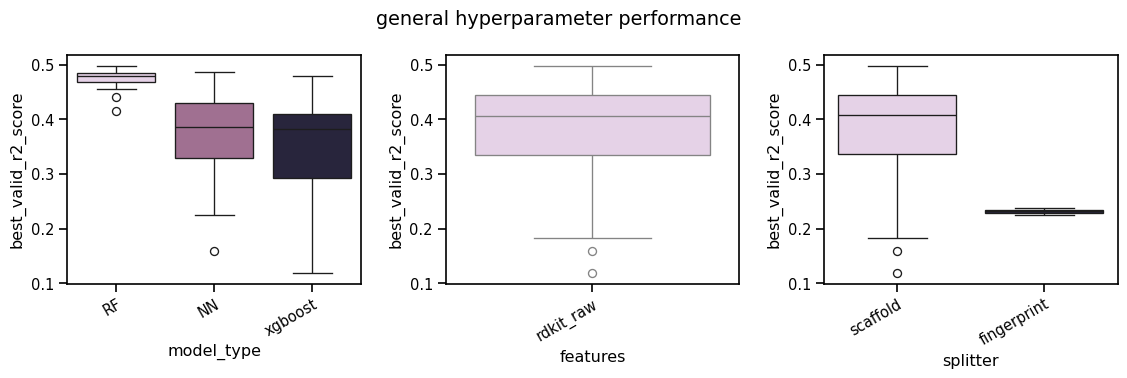

In [12]:
## make sure others work 
hpp.plot_hyper_perf(result_df)

We are getting the same error here. Let's see how the function works. Okay, it is because it is using the same `_prep_perf_df` function

In [21]:
def plot_hyper_perf(df, scoretype='r2_score', subset='valid', model_type='general'):
    """This function creates boxplots or scatter plots of performance scores based on their hyperparameters.
    
    Args:
        df (pd.DataFrame): A dataframe containing model performances from a hyperparameter search. Best practice is to use get_multitask_perf_from_tracker() or get_filesystem_perf_results().
        
        scoretype (str): the score type you want to use. Valid options can be found in get_score_types()
        
        subset (str): the subset of scores you'd like to plot from 'train', 'valid' and 'test'.

        model_type (str): the type of model you want to visualize. Options include 'general' (features and splits), 'RF', 'NN', 'xgboost', and limited functionality for 'AttentiveFPModel', 'GCNModel', 'GraphConvModel', 'MPNNModel', and 'PytorchMPNNModel'.
    """

    sns.set_context('notebook')
    perf_track_df=_prep_perf_df(df).reset_index(drop=True)
    if model_type !='general':
        perf_track_df=perf_track_df[perf_track_df.model_type==model_type]
    winnertype= f'best_{subset}_{scoretype}'

    feats=plot_dict[model_type]
    ncols=3
    nrows=int(np.ceil(len(feats)/ncols))

    helix_dict={'NN':(0,0.40),'RF':(0,2.00),'xgboost':(0,2.75),'general':(60,0.2)}

    if model_type=='xgboost':
        for feat in feats:
            try: perf_track_df[feat]=perf_track_df[feat].round(3)
            except: continue
                
    fig, ax = plt.subplots(nrows,ncols,figsize=(ncols*4,nrows*4))
    ax=ax.ravel()
    for i, feat in enumerate(feats):
        try: rot,start=helix_dict[model_type]
        except: rot,start=(-0.2,0)
        if feat in perf_track_df.columns:    
            if perf_track_df[feat].nunique()>12:
                sns.scatterplot(x=feat, y=winnertype, data=perf_track_df, ax=ax[i])
                old_ticks=ax[i].get_xticks()
                old_labs=ax[i].get_xticklabels()
                ticks=[]
                labs=[]
                for tick, lab in zip(old_ticks, old_labs):
                    if tick>=0:
                        ticks.append(tick)
                        labs.append(lab)
            else:       
                sns.boxplot(x=feat,y=winnertype,hue=feat,palette=sns.cubehelix_palette(perf_track_df[feat].nunique(), rot=rot,start=start,), data=perf_track_df, ax=ax[i],legend=False)
                ticks=ax[i].get_xticks()
                labs=ax[i].get_xticklabels()
            ax[i].set_xticks(ticks) # avoid warning by including this line
            ax[i].set_xticklabels(labs, rotation=30, ha='right', rotation_mode='anchor' )
        ax[i].set_xlabel(feat)
    fig.suptitle(f'{model_type} hyperparameter performance')
    plt.tight_layout()


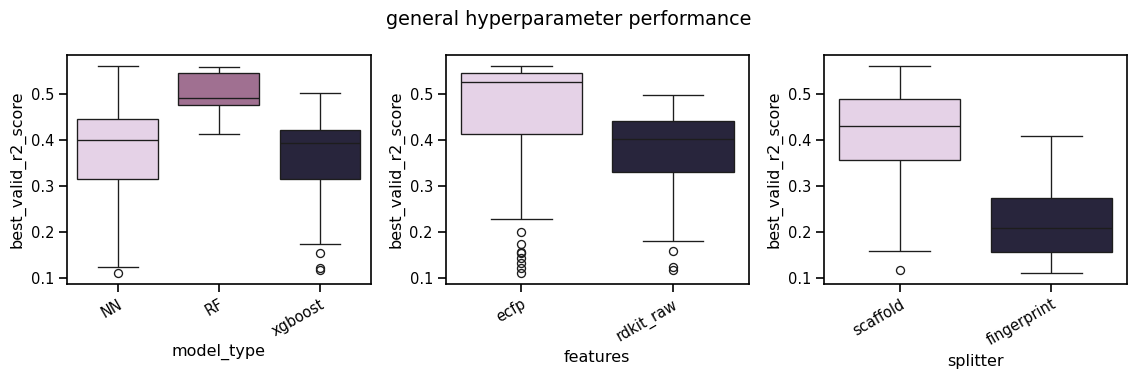

In [22]:
# running with my local revised function
plot_hyper_perf(result_df)

slay, it looks like it works. Let's keep looking to make sure everything matches up. I dont think anything will match up because of the new dataset it is working with. 

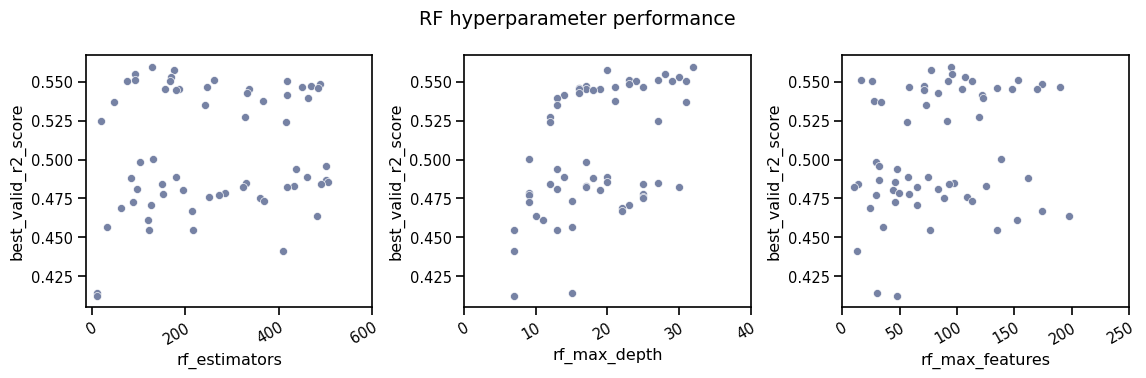

In [36]:
plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='r2_score')

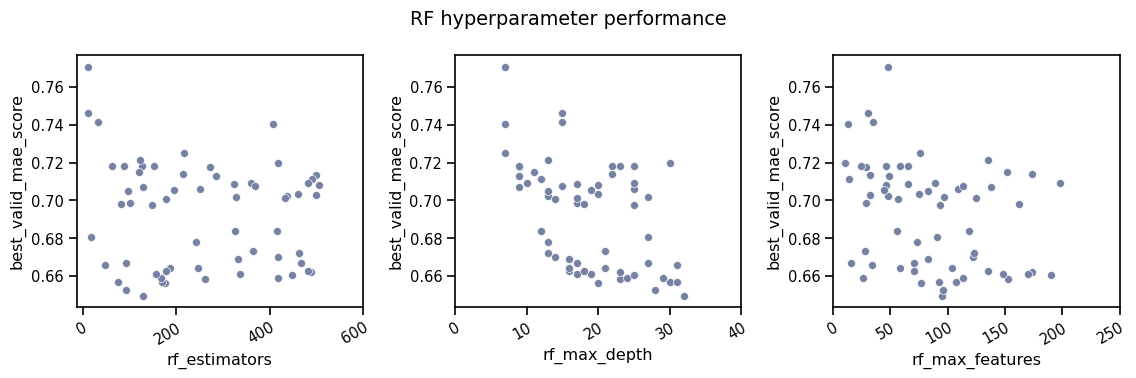

In [37]:
plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='mae_score')

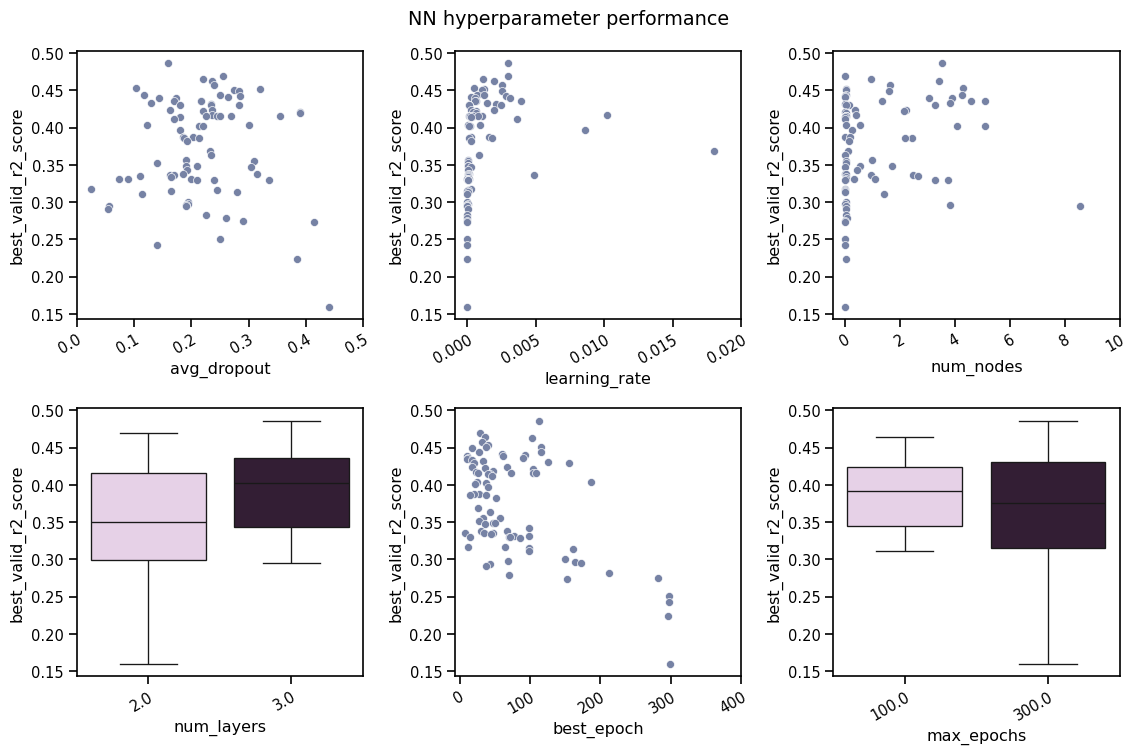

In [38]:
subsetted=result_df[result_df.splitter=='scaffold']
subsetted=subsetted[subsetted.features=='rdkit_raw']

hpp.plot_hyper_perf(subsetted, model_type='NN')

In [39]:
def plot_xg_perf(df, scoretype='r2_score',subset='valid'):
    """This function plots scatterplots of performance scores based on their XG hyperparameters.
    
    Args:
        df (pd.DataFrame): A dataframe containing model performances from a hyperparameter search. Best practice is to use get_multitask_perf_from_tracker() or get_filesystem_perf_results().
        
        scoretype (str): the score type you want to use. Valid options can be found in get_score_types()
        
        subset (str): the subset of scores you'd like to plot from 'train', 'valid' and 'test'.
    """
    sns.set_context('poster')
    perf_track_df=df.copy().reset_index(drop=True)
    plot_df=perf_track_df[perf_track_df.model_type=='xgboost'].copy()
    winnertype= f'best_{subset}_{scoretype}'
    if len(plot_df)>0:
        feat1 = 'xgb_learning_rate'; feat2 = 'xgb_gamma'
        for feat in [feat1,feat2]:
            plot_df[feat]=plot_df[feat].round(3)
        hue=feat2
        plot_df = plot_df.sort_values([feat1, feat2])
        #plot_df[f'{feat1}/{feat2}'] = ['%s / %s' % (mf,est) for mf,est in zip(plot_df[feat1], plot_df[feat2])]
        with sns.axes_style("whitegrid"):
            fig,ax = plt.subplots(1,figsize=(40,15))
            if plot_df[hue].nunique()<13:
                palette=sns.cubehelix_palette(plot_df[hue].nunique())
            else:
                palette=sns.cubehelix_palette(as_cmap=True)
            sns.scatterplot(x=feat1, y=winnertype, hue=hue, 
                                palette=palette, 
                                data=plot_df, ax=ax)
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
            plt.xticks(rotation=30, ha='right')
            ax.set_title(f'XGboost model performance');
    else: print('There are no XGBoost models in this set.')

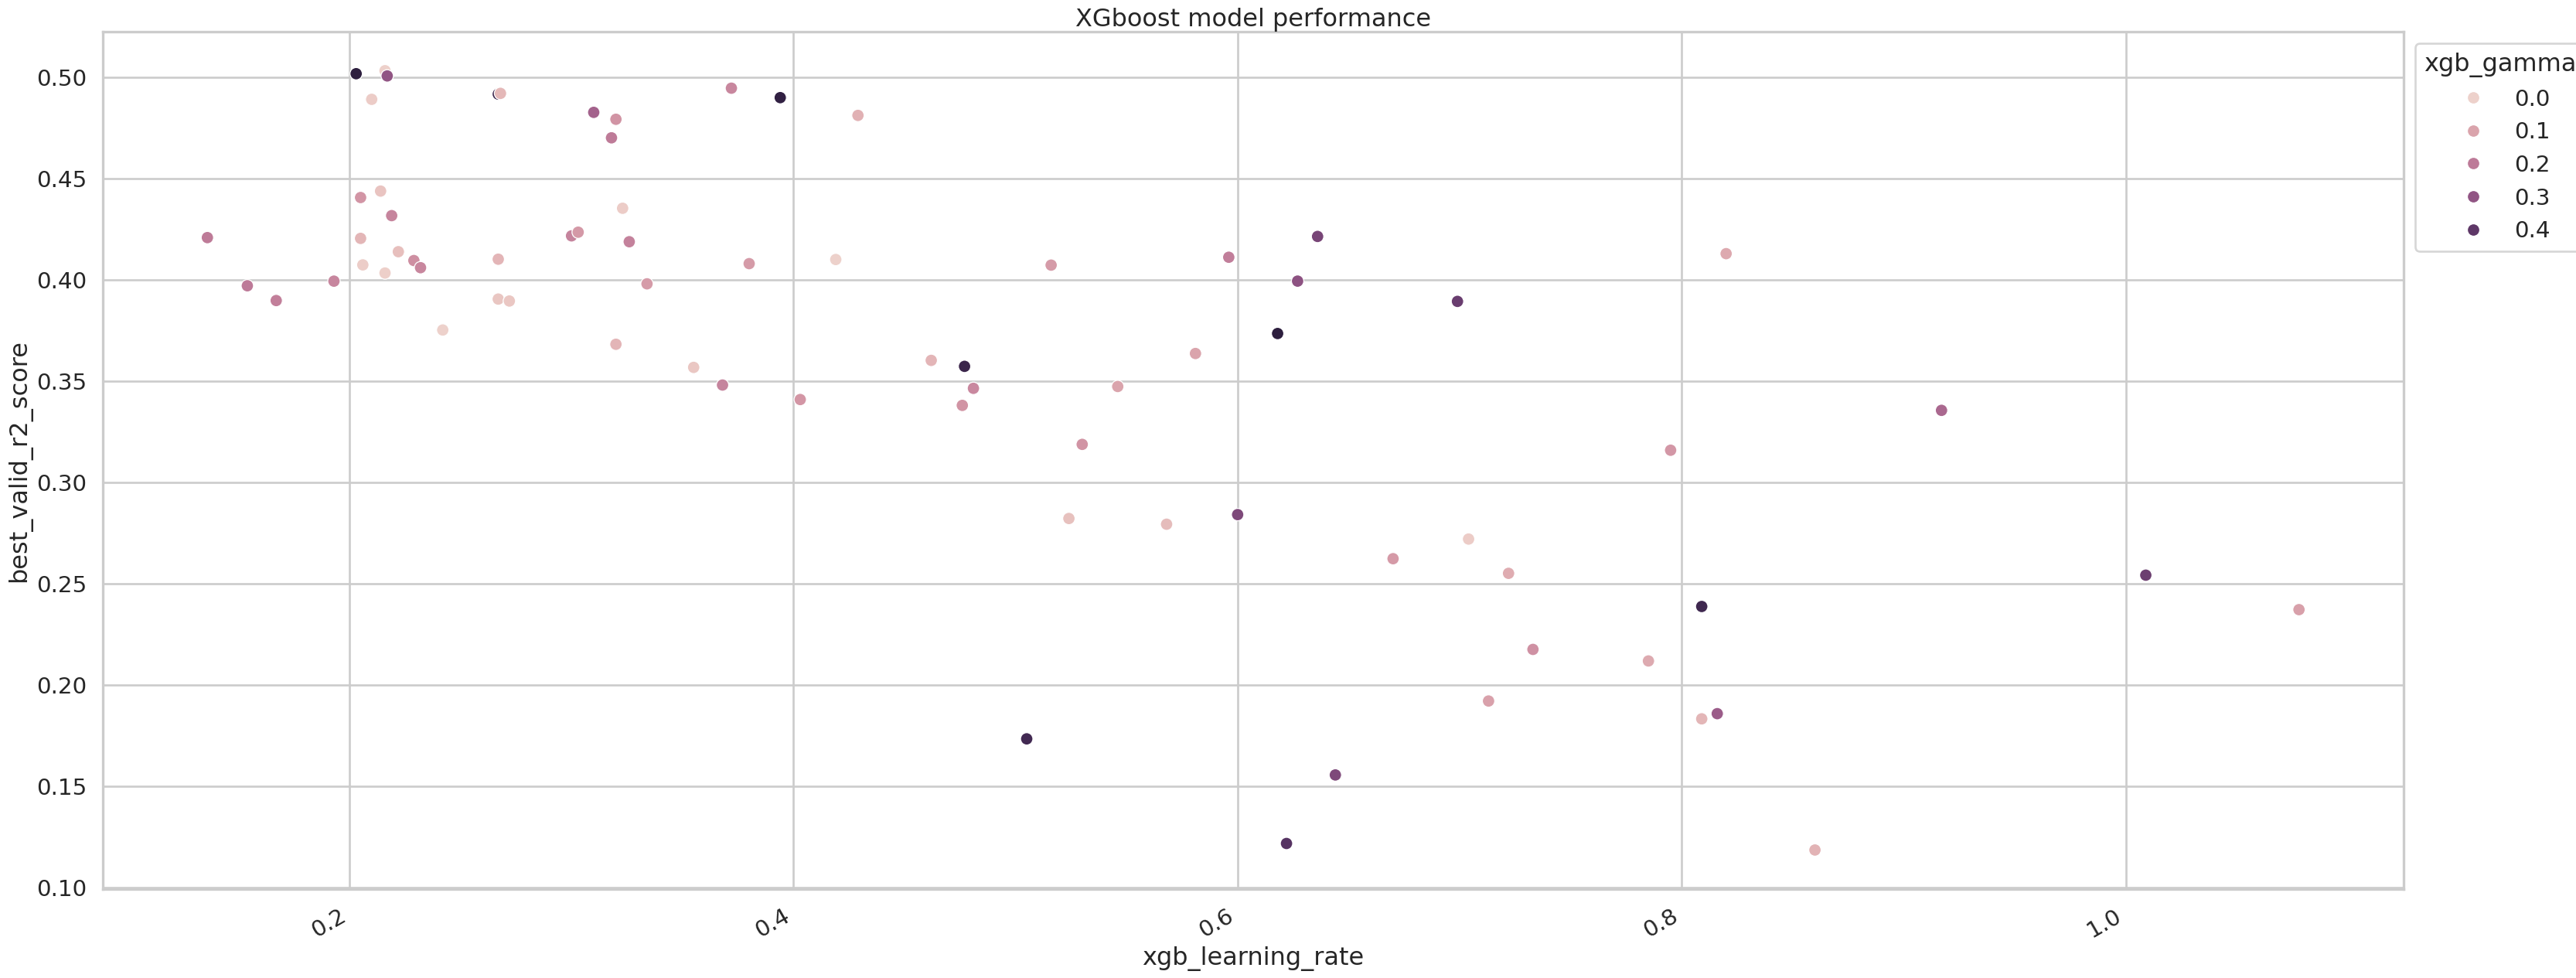

In [40]:
plot_xg_perf(result_df)

## Checking "Evaluation of a Single Model" 

In [41]:
winnertype='best_valid_r2_score'

# result_df=cm.get_filesystem_perf_results(result_dir='dataset/SLC6A3_models/', pred_type='regression')

result_df=pd.read_csv('dataset/SLC6A3_models/07_example_pred_df.csv', index_col=0)
result_df=result_df.sort_values(winnertype, ascending=False)

In [42]:
result_df.iloc[0][['features','splitter','best_valid_r2_score']]

features                   ecfp
splitter               scaffold
best_valid_r2_score    0.562091
Name: 310, dtype: object

In [43]:
result_df.iloc[0].model_parameters_dict

'{"best_epoch": 24, "dropouts": [0.27866421599874197, 0.3041982566364109, 0.29943876674824], "layer_sizes": [369, 283, 146], "learning_rate": 8.28816038984145e-05, "max_epochs": 100}'

In [44]:
result_df.iloc[0].model_path

'dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz'

### This was where the main issue was. 
The scatter plots looked a lot different. The ones created in this module had much smaller points and a winder range it seems in the x and y directions. 

2024-05-24 16:20:07,604 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz, 1.6.0
2024-05-24 16:20:07,610 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz version = "1.6", AMPL version = "1.6"


['/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpoxkqmuuc/best_model/checkpoint1.pt']
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpoxkqmuuc/best_model/checkpoint1.pt


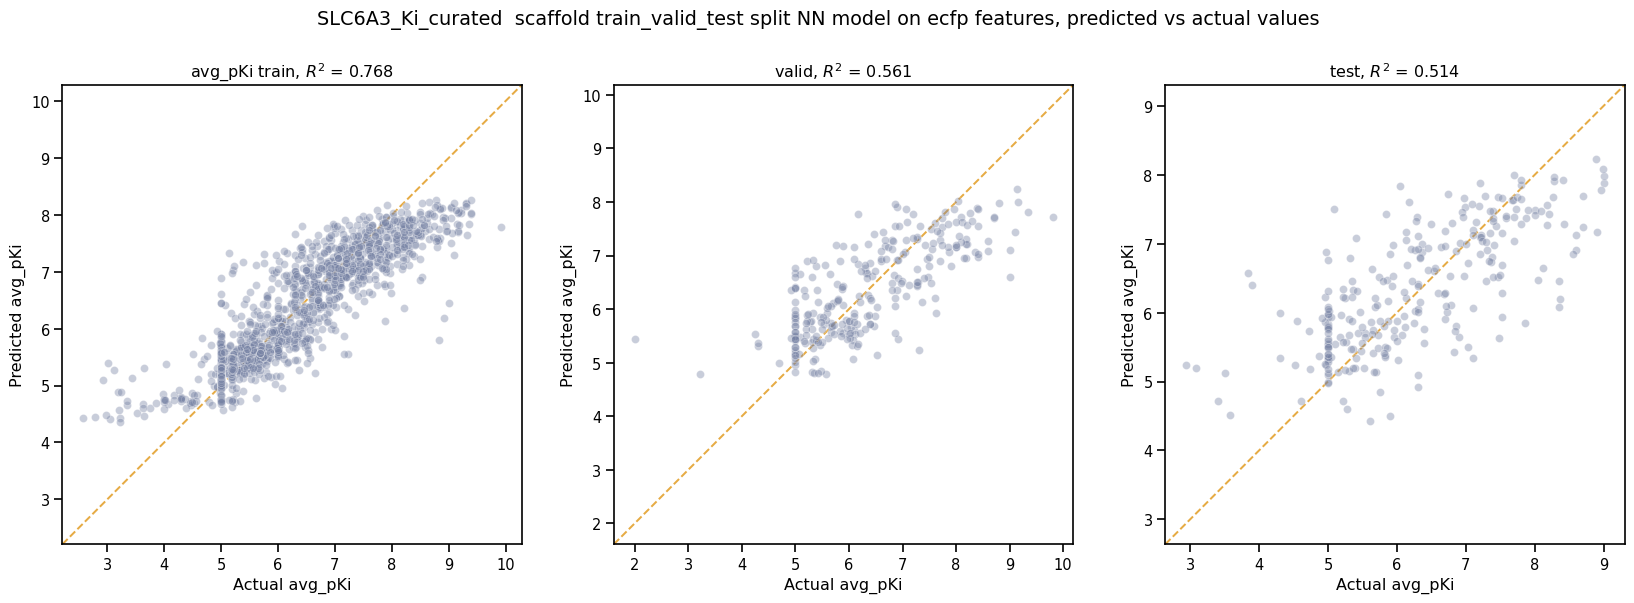

In [46]:
# plot best model, an NN
import importlib
from atomsci.ddm.pipeline import perf_plots as pp
importlib.reload(pp)
model_path=result_df.iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)

I'm hypothesizing that the function `plot_pred_vs_actual_from_file` are different or one of the functions it is calling is different. Let me try running the old version of the function and see if it works (the one from the master branch on GitHub).

2024-05-24 16:37:09,725 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz, 1.6.0
2024-05-24 16:37:09,729 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz version = "1.6", AMPL version = "1.6"


['/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpq8t384xb/best_model/checkpoint1.pt']
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpq8t384xb/best_model/checkpoint1.pt


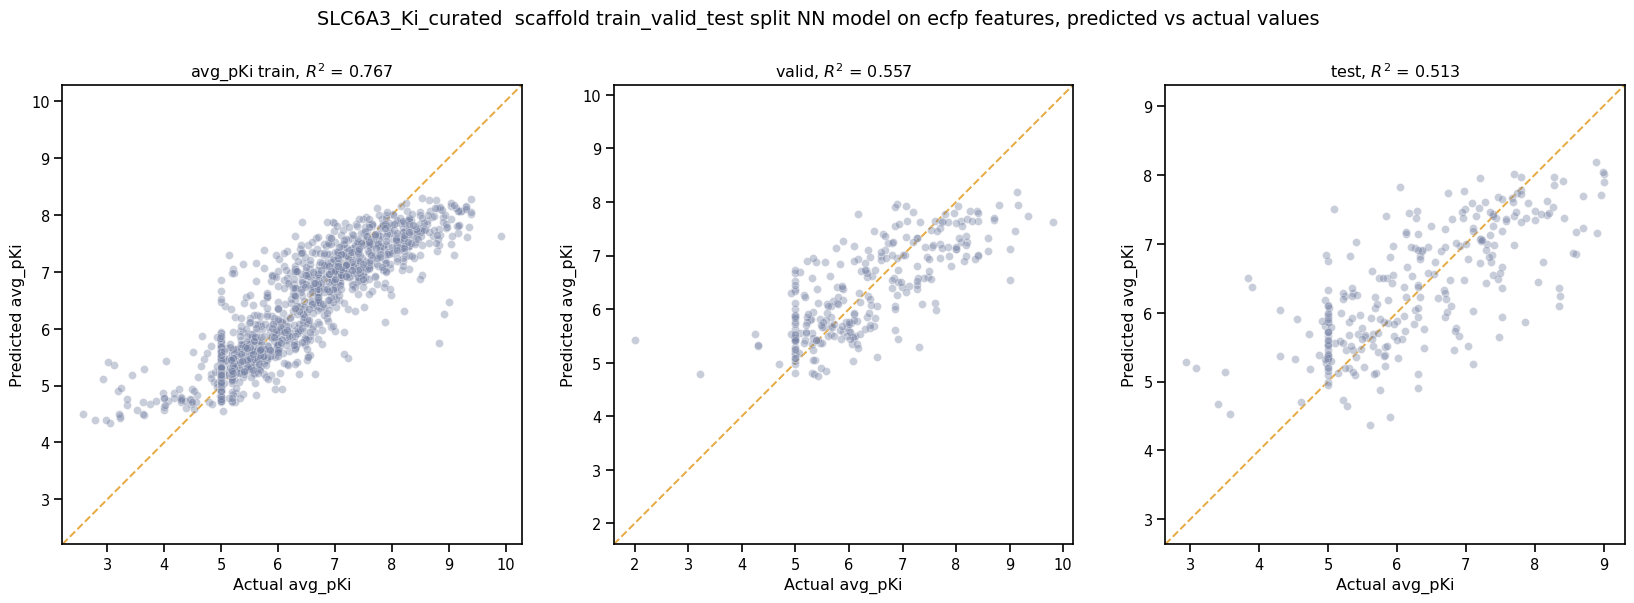

In [54]:
pp.plot_pred_vs_actual_from_file(model_path)

In [24]:
def _prep_perf_df(df):
    """This function splits columns that contain lists into individual columns to use for plotting later.
    
    Args:
        df (pd.DataFrame): A dataframe containing model performances from a hyperparameter search. Best practice is to use get_multitask_perf_from_tracker() or get_filesystem_perf_results().
        
    Returns:
        perf_track_df (pd.DataFrame): a new df with modified and extra columns.
    """
    perf_track_df=df.copy()

    if 'model_parameters_dict' in perf_track_df:
        # reset the index so the dataframes merge correctly
        perf_track_df.reset_index(drop=True, inplace=True)
        exp=pd.DataFrame(perf_track_df.model_parameters_dict.tolist())
        exp['model_uuid']=perf_track_df.model_uuid
        perf_track_df=perf_track_df.merge(exp)
    
    if 'NN' in perf_track_df.model_type.unique():
        
        cols=['dummy_nodes_1','dummy_nodes_2','dummy_nodes_3']
        
        # dropouts
        tmp=perf_track_df.dropouts.astype(str).str.strip('[]').str.split(pat=',', expand=True).astype(float)
        n=len(tmp.columns)
        perf_track_df[cols[0:n]]=tmp
        perf_track_df['avg_dropout']=perf_track_df[cols[0:n]].mean(axis=1)
        
        # layer sizes
        tmp= perf_track_df.layer_sizes.astype(str).str.strip('[]').str.split(pat=',', expand=True).astype(float)
        perf_track_df[cols[0:n]]=tmp
        perf_track_df['num_layers'] = n-perf_track_df[cols[0:n]].isna().sum(axis=1)
        perf_track_df[cols[0:n]]=perf_track_df[cols[0:n]].fillna(value=1).astype(int)
        perf_track_df['num_nodes']=perf_track_df[cols[0:n]].product(axis=1)
        perf_track_df.num_nodes=perf_track_df.num_nodes.astype(float)
        # perf_track_df=perf_track_df.drop(columns=cols[0:n])
        
        perf_track_df.loc[perf_track_df.model_type != "NN", 'layer_sizes']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'num_layers']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'num_nodes']=np.nan
        perf_track_df.loc[perf_track_df.model_type != "NN", 'avg_dropout']=np.nan
    
    return perf_track_df


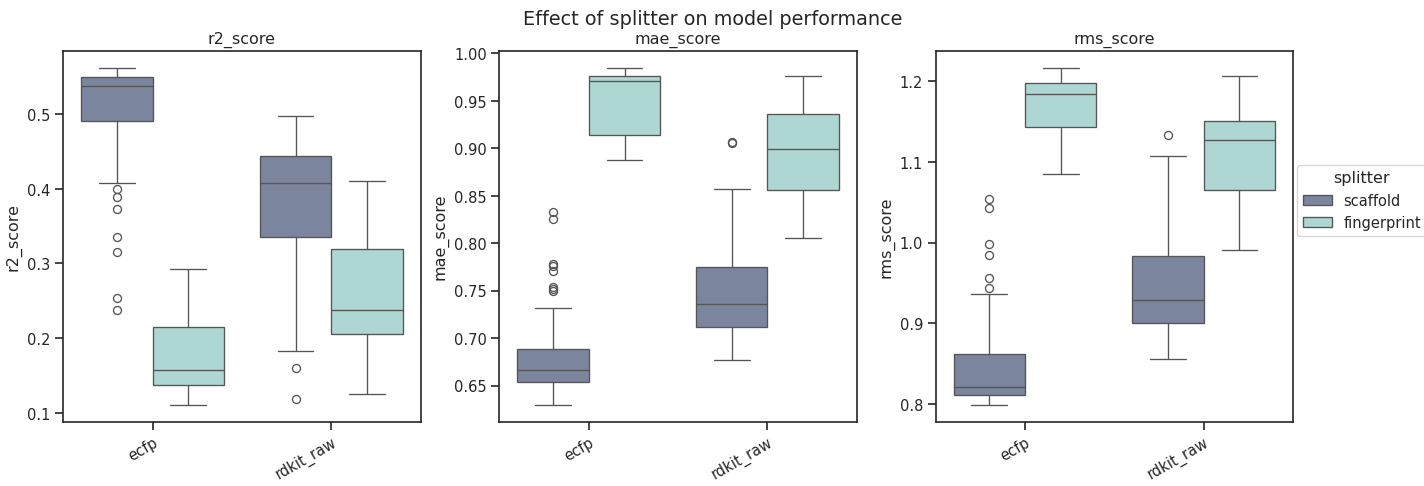

In [25]:
plot_split_perf(result_df, subset='valid')